In [1]:
#IMPORT DELLE LIBRERIE
import numpy as np 
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import zipfile

import cv2
import os
import glob
import gc

import skimage.transform as trans
from skimage import io, color
from skimage.util import random_noise

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
#DOWNLOAD DEL DATASET
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

mkdir: cannot create directory ‘data_faces’: File exists


In [3]:
#UNZIP DEL DATASET
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [4]:
#FUNZIONE PER CARICARE IN MEMORIA LE IMMAGINI
def read_images(img_dir, xdim, ydim, nmax=50000) :
    label = 0
    label_names = []
    X = []
    y=[]
    for dirname in os.listdir(img_dir):
        print(dirname)
        label_names.append(dirname)
        data_path = os.path.join(img_dir + "/" + dirname,'*g')
        files = glob.glob(data_path)
        n=0
        for f1 in files:
            if n>=nmax : break
            img = cv2.imread(f1) 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            img = cv2.resize(img, (xdim,ydim))
            X.append(np.array(img)) 
            n=n+1
        print(n,' images lues')
    X = np.array(X)
    gc.collect() 
    return X

In [5]:
#CARICO IN MEMORIA 100000 IMMAGINI
X= read_images("data_faces", 64, 64, 75000)

img_align_celeba
75000  images lues


In [6]:
#SPLIT DEL DATASET PER IL TEST SET
X_train, X_test = train_test_split(X,
    test_size=0.2)

#SPLIT DEL DATASET PER IL VALIDATION SET
X_train, X_val = train_test_split(X_train, 
    test_size=0.1)

#MODIFICA DI COME VENGONO SALVATE LE IMMAGINI IN MEMORIA
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255

In [7]:
#DIMENSIONI DEL TRAINING SET
X_train.shape

(54000, 64, 64, 3)

In [8]:
#DIMENSIONI DEL TEST SET
X_test.shape

(15000, 64, 64, 3)

In [9]:
#DIMENSIONI DEL VALIDATION SET
X_val.shape

(6000, 64, 64, 3)

In [10]:
X_train_1=X_train[36000:]
X_train_2=X_train[:36000]

In [11]:
#AGGIUNGIAMO IL RUMORE ALLE IMMAGINI DEL TRAINING SET
noise_factor = 0.2

X_train_1_noisy = random_noise(X_train_1, mode="s&p",clip=True, amount=noise_factor)
X_train_2_noisy = random_noise(X_train_2, mode="s&p",clip=True, amount=noise_factor)
X_train_noisy=np.concatenate((X_train_2_noisy, X_train_1_noisy), axis=0)

In [12]:
#PULIZIA MEMORIA
X_train_1=np.delete
X_train_2=np.delete
X_train_1_noisy=np.delete
X_train_2_noisy=np.delete

In [13]:
#AGGIUNGIAMO IL RUMORE ALLE IMMAGINI DEL TEST SET E DEL VALIDATION SET
X_test_noisy = random_noise(X_test, mode="s&p",clip=True, amount=noise_factor)
X_val_noisy = random_noise(X_val, mode="s&p",clip=True, amount=noise_factor)

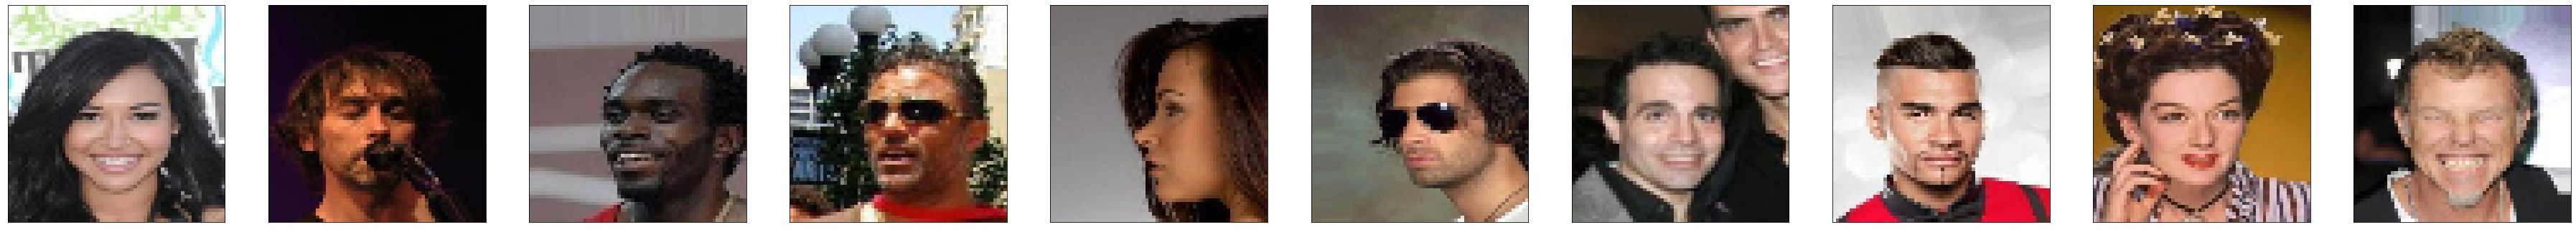

In [14]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TRAINING SET
n = 10

plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_train[i].reshape(64, 64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

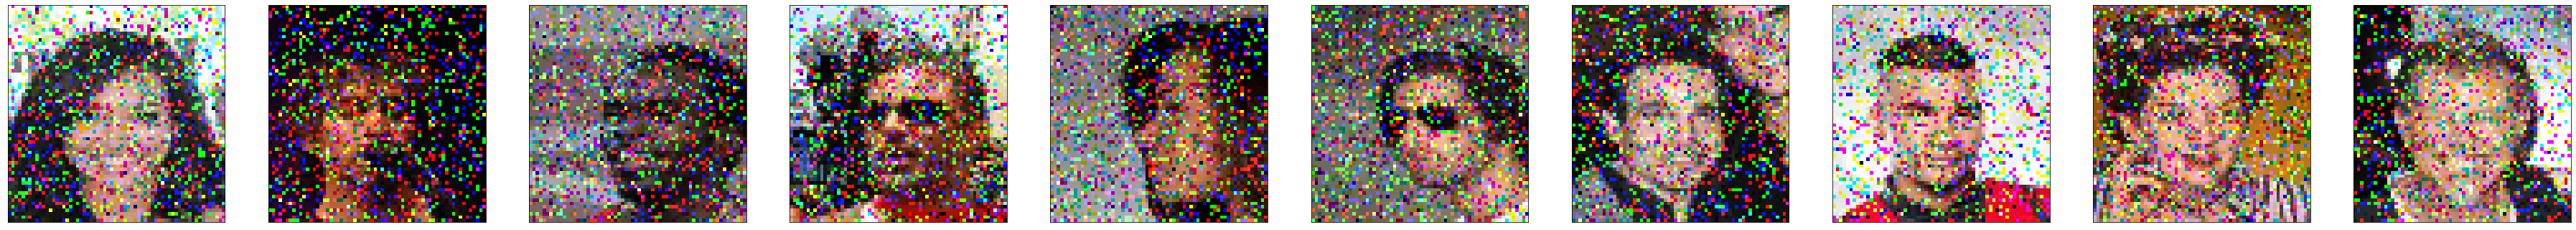

In [15]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TRAINING SET COL RUMORE
n = 10

plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_train_noisy[i].reshape(64, 64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
def selective_kernel_feature_fusion(
    multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3
):
    channels = list(multi_scale_feature_1.shape)[-1]
    combined_feature = Add()(
        [multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3]
    )
    gap = GlobalAveragePooling2D()(combined_feature)
    channel_wise_statistics = tf.reshape(gap, shape=(-1, 1, 1, channels))
    compact_feature_representation = Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(channel_wise_statistics)
    feature_descriptor_1 = Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_2 = Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_3 = Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_1 = multi_scale_feature_1 * feature_descriptor_1
    feature_2 = multi_scale_feature_2 * feature_descriptor_2
    feature_3 = multi_scale_feature_3 * feature_descriptor_3
    aggregated_feature = Add()([feature_1, feature_2, feature_3])
    return aggregated_feature

In [17]:
def spatial_attention_block(input_tensor):
    average_pooling = tf.reduce_max(input_tensor, axis=-1)
    average_pooling = tf.expand_dims(average_pooling, axis=-1)
    max_pooling = tf.reduce_mean(input_tensor, axis=-1)
    max_pooling = tf.expand_dims(max_pooling, axis=-1)
    concatenated = Concatenate(axis=-1)([average_pooling, max_pooling])
    feature_map = Conv2D(1, kernel_size=(1, 1))(concatenated)
    feature_map = tf.nn.sigmoid(feature_map)
    return input_tensor * feature_map


def channel_attention_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    average_pooling = GlobalAveragePooling2D()(input_tensor)
    feature_descriptor = tf.reshape(average_pooling, shape=(-1, 1, 1, channels))
    feature_activations = Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(feature_descriptor)
    feature_activations = Conv2D(
        filters=channels, kernel_size=(1, 1), activation="sigmoid"
    )(feature_activations)
    return input_tensor * feature_activations


def dual_attention_unit_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    feature_map = Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(input_tensor)
    feature_map = Conv2D(channels, kernel_size=(3, 3), padding="same")(
        feature_map
    )
    channel_attention = channel_attention_block(feature_map)
    spatial_attention = spatial_attention_block(feature_map)
    concatenation = Concatenate(axis=-1)([channel_attention, spatial_attention])
    concatenation = Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return Add()([input_tensor, concatenation])

In [18]:
# Recursive Residual Modules


def down_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = MaxPooling2D()(main_branch)
    main_branch = Conv2D(channels * 2, kernel_size=(1, 1))(main_branch)
    skip_branch = MaxPooling2D()(input_tensor)
    skip_branch = Conv2D(channels * 2, kernel_size=(1, 1))(skip_branch)
    return Add()([skip_branch, main_branch])


def up_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = UpSampling2D()(main_branch)
    main_branch = Conv2D(channels // 2, kernel_size=(1, 1))(main_branch)
    skip_branch = UpSampling2D()(input_tensor)
    skip_branch = Conv2D(channels // 2, kernel_size=(1, 1))(skip_branch)
    return Add()([skip_branch, main_branch])


# MRB Block
def multi_scale_residual_block(input_tensor, channels):
    # features
    level1 = input_tensor
    level2 = down_sampling_module(input_tensor)
    level3 = down_sampling_module(level2)
    # DAU
    level1_dau = dual_attention_unit_block(level1)
    level2_dau = dual_attention_unit_block(level2)
    level3_dau = dual_attention_unit_block(level3)
    # SKFF
    level1_skff = selective_kernel_feature_fusion(
        level1_dau,
        up_sampling_module(level2_dau),
        up_sampling_module(up_sampling_module(level3_dau)),
    )
    level2_skff = selective_kernel_feature_fusion(
        down_sampling_module(level1_dau), level2_dau, up_sampling_module(level3_dau)
    )
    level3_skff = selective_kernel_feature_fusion(
        down_sampling_module(down_sampling_module(level1_dau)),
        down_sampling_module(level2_dau),
        level3_dau,
    )
    # DAU 2
    level1_dau_2 = dual_attention_unit_block(level1_skff)
    level2_dau_2 = up_sampling_module((dual_attention_unit_block(level2_skff)))
    level3_dau_2 = up_sampling_module(
        up_sampling_module(dual_attention_unit_block(level3_skff))
    )
    # SKFF 2
    skff_ = selective_kernel_feature_fusion(level1_dau_2, level2_dau_2, level3_dau_2)
    conv = Conv2D(channels, kernel_size=(3, 3), padding="same")(skff_)
    return Add()([input_tensor, conv])

In [19]:
def recursive_residual_group(input_tensor, num_mrb, channels):
    conv1 = Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_mrb):
        conv1 = multi_scale_residual_block(conv1, channels)
    conv2 = Conv2D(channels, kernel_size=(3, 3), padding="same")(conv1)
    return Add()([conv2, input_tensor])


def mirnet_model(num_rrg, num_mrb, channels):
    input_tensor = Input(shape=[None, None, 3])
    x1 = Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_rrg):
        x1 = recursive_residual_group(x1, num_mrb, channels)
    conv = Conv2D(3, kernel_size=(3, 3), padding="same")(x1)
    output_tensor = Add()([input_tensor, conv])
    return Model(input_tensor, output_tensor)


model = mirnet_model(num_rrg=3, num_mrb=2, channels=64)

In [20]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


import keras

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer, loss=charbonnier_loss, metrics=[peak_signal_noise_ratio]
)

In [21]:
#TRAINING DEL MODELLO
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=1)
history = model.fit(X_train_noisy, X_train, epochs=100, batch_size=16, validation_data=(X_val_noisy,X_val), callbacks=[callback])

Epoch 1/100
3375/3375 [==============================] - 3452s 1s/step - loss: 0.0368 - peak_signal_noise_ratio: 73.8313 - val_loss: 0.0165 - val_peak_signal_noise_ratio: 79.1107
Epoch 2/100
3375/3375 [==============================] - 3397s 1s/step - loss: 0.0130 - peak_signal_noise_ratio: 81.1720 - val_loss: 0.0104 - val_peak_signal_noise_ratio: 82.6942
Epoch 3/100
3375/3375 [==============================] - 3396s 1s/step - loss: 0.0091 - peak_signal_noise_ratio: 83.6190 - val_loss: 0.0080 - val_peak_signal_noise_ratio: 84.6397
Epoch 4/100
3375/3375 [==============================] - 3390s 1s/step - loss: 0.0068 - peak_signal_noise_ratio: 85.3779 - val_loss: 0.0059 - val_peak_signal_noise_ratio: 86.1269
Epoch 5/100
3375/3375 [==============================] - 3386s 1s/step - loss: 0.0056 - peak_signal_noise_ratio: 86.5505 - val_loss: 0.0051 - val_peak_signal_noise_ratio: 87.1284
Epoch 6/100
3375/3375 [==============================] - 3390s 1s/step - loss: 0.0048 - peak_signal_noise

In [22]:
#TEST DEL MODELLO SUL TEST SET
predict = model.predict(X_test_noisy)

469/469 [==============================] - 308s 642ms/step


In [23]:
predict.shape

(15000, 64, 64, 3)

In [24]:
n=10

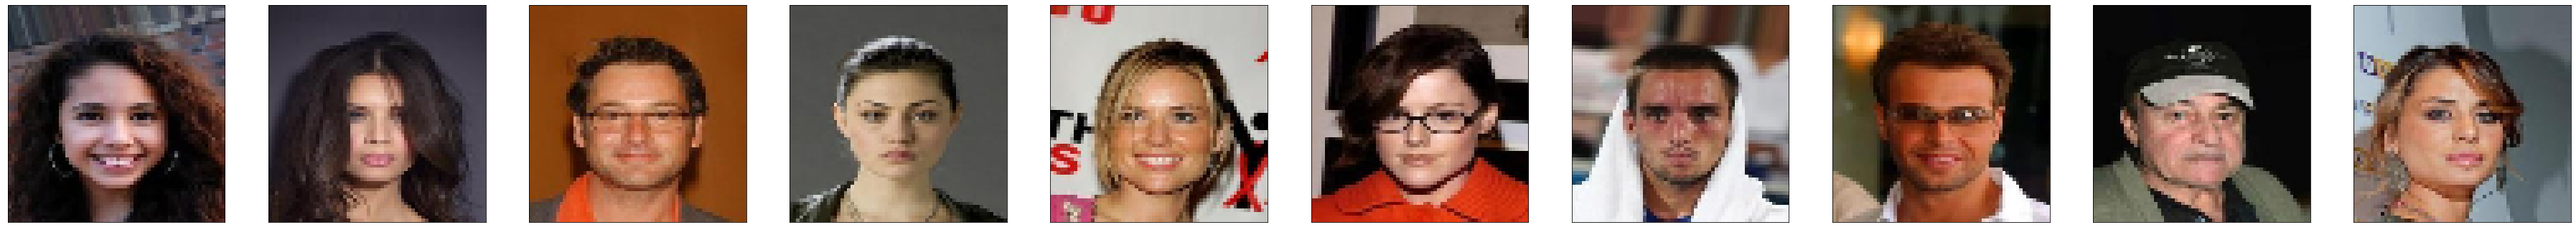

In [25]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

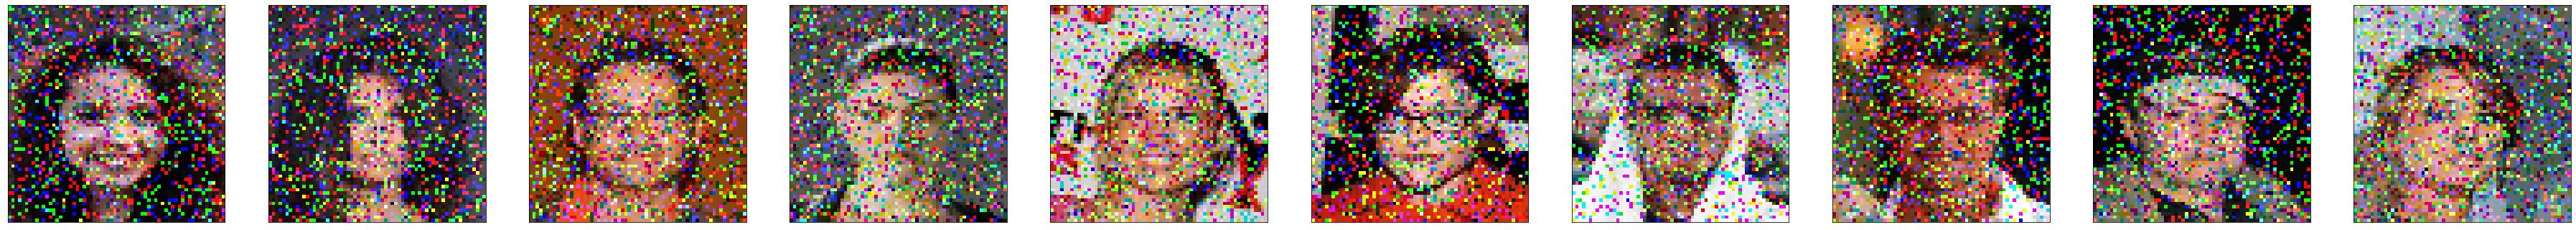

In [26]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET COL RUMORE
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

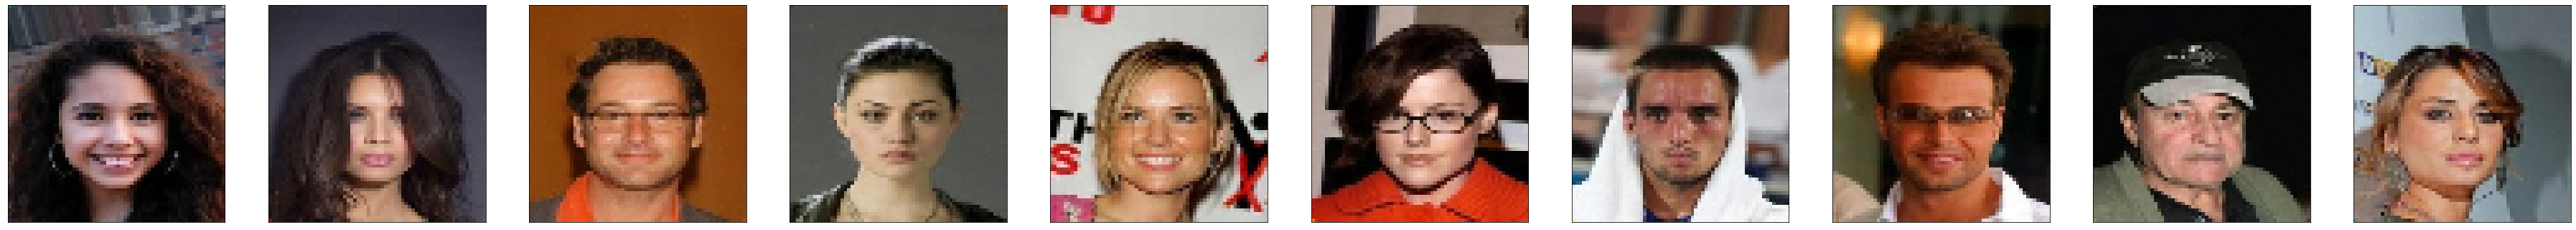

In [27]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET SENZA RUMORE (OUTPUT DELLA UNET)
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(predict[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [28]:
NUMBER_OF_TEST_IMAGES = len(X_test)

mse = mean_squared_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3))
mae = mean_absolute_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3))
rmse = np.sqrt(mean_squared_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3)))

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.00013138783
Mean Absolute Error: 0.00428203
Root Mean Squared Error: 0.011462453


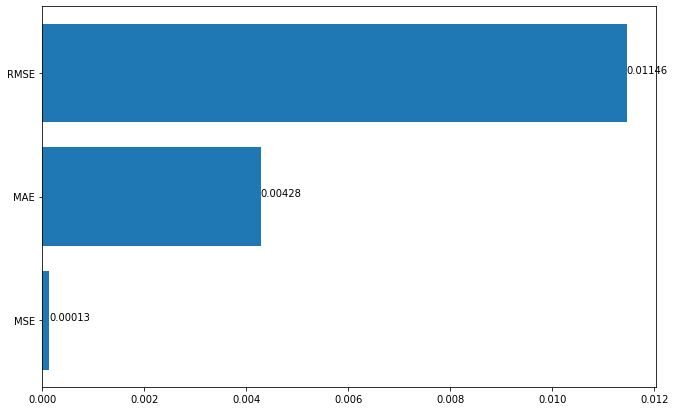

In [29]:
plt.figure(figsize = (11,7))
x = ["MSE","MAE","RMSE"]
y = [mse,mae,rmse]
plt.barh(x, y)
  
for index, value in enumerate(y):
    plt.text(value, index,
             str(value)[:7])
plt.show()